In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# setup device for training
# use gpu if available to make things faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using: {device}")

# simple cnn model for mnist
# keeping it small so experiments run quickly
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# prepare mnist data
# normalize to help with training
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(train_data, batch_size=64, shuffle=True)

def train_and_collect(epochs=8, save_every=3):
    # train model while collecting weights and gradients
    # we run multiple times to see different optimization paths
    model = CNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    weight_snapshots = []
    acc_values = []
    loss_values = []
    grad_values = []

    for run in range(8):
        # reset model weights for each run
        model.apply(lambda m: torch.nn.init.xavier_uniform_(m.weight) if hasattr(m, 'weight') else None)
        
        for epoch in range(epochs):
            total_loss = 0
            total_grad = 0

            for data, target in data_loader:
                data, target = data.to(device), target.to(device)
                
                # forward pass
                output = model(data)
                loss = loss_fn(output, target)
                
                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # calculate gradient norm
                grad_norm = sum(p.grad.norm().item() ** 2 for p in model.parameters() if p.grad is not None) ** 0.5
                total_grad += grad_norm
                
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(data_loader)
            avg_grad = total_grad / len(data_loader)

            # save weights every few epochs
            if epoch % save_every == 0:
                all_weights = np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters()])
                weight_snapshots.append(all_weights)
                
                # calculate accuracy on last batch
                accuracy = (torch.argmax(output, dim=1) == target).float().mean().item()
                acc_values.append(accuracy)
            
            loss_values.append(avg_loss)
            grad_values.append(avg_grad)

        print(f"run {run+1} done - loss: {avg_loss:.4f}, grad: {avg_grad:.4f}")

    return weight_snapshots, acc_values, loss_values, grad_values

def plot_weight_path(weights, accs):
    # visualize how weights change during optimization
    # use pca to reduce dimensions so we can plot in 2d
    weights_matrix = np.array(weights)
    pca = PCA(n_components=2)
    weights_2d = pca.fit_transform(weights_matrix)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(weights_2d[:, 0], weights_2d[:, 1], c=accs, cmap='viridis', edgecolor='black')
    plt.colorbar(scatter, label='accuracy')
    plt.title('optimization path in weight space')
    plt.xlabel('first component')
    plt.ylabel('second component')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_grad_and_loss(grads, losses):
    # plot gradient norm and loss on same chart
    # this shows how gradients change as loss decreases
    plt.figure(figsize=(12, 6))
    plt.plot(grads, label='gradient norm', color='blue', alpha=0.7)
    plt.plot(losses, label='loss', color='red', alpha=0.7)
    plt.title('gradient norm and loss during training')
    plt.xlabel('iterations')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_minimal_analysis(weights, losses):
    # analyze relationship between weight norms and loss
    # this approximates the minimal ratio concept from the assignment
    sampled_losses = losses[::3]  # sample losses to match weight collection frequency
    weight_norms = [np.linalg.norm(w) for w in weights]
    
    # check if we have matching lengths
    if len(weight_norms) != len(sampled_losses):
        print(f"length mismatch: weights={len(weight_norms)}, losses={len(sampled_losses)}")
        min_len = min(len(weight_norms), len(sampled_losses))
        weight_norms = weight_norms[:min_len]
        sampled_losses = sampled_losses[:min_len]

    plt.figure(figsize=(10, 6))
    plt.scatter(weight_norms, sampled_losses, c='red', edgecolor='black', alpha=0.7)
    plt.title('weight norm vs loss at critical points')
    plt.xlabel('weight norm (minimal ratio proxy)')
    plt.ylabel('loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

using: cpu


run 1 done - loss: 0.0628, grad: 1.3933
run 2 done - loss: 0.0619, grad: 1.3988
run 3 done - loss: 0.0651, grad: 1.4475
run 4 done - loss: 0.0664, grad: 1.4405
run 5 done - loss: 0.0654, grad: 1.4422
run 6 done - loss: 0.0660, grad: 1.4745
run 7 done - loss: 0.0652, grad: 1.4630
run 8 done - loss: 0.0647, grad: 1.4551


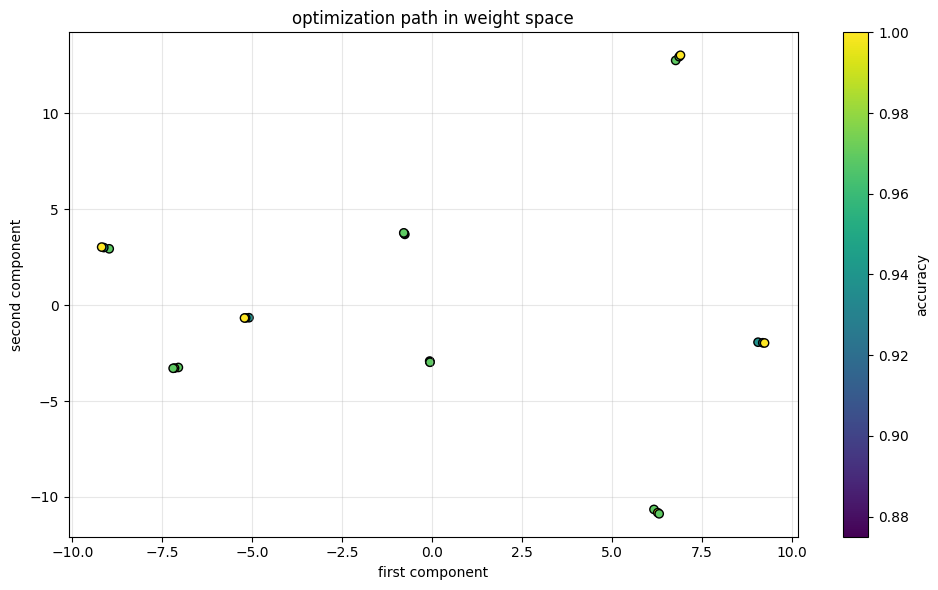

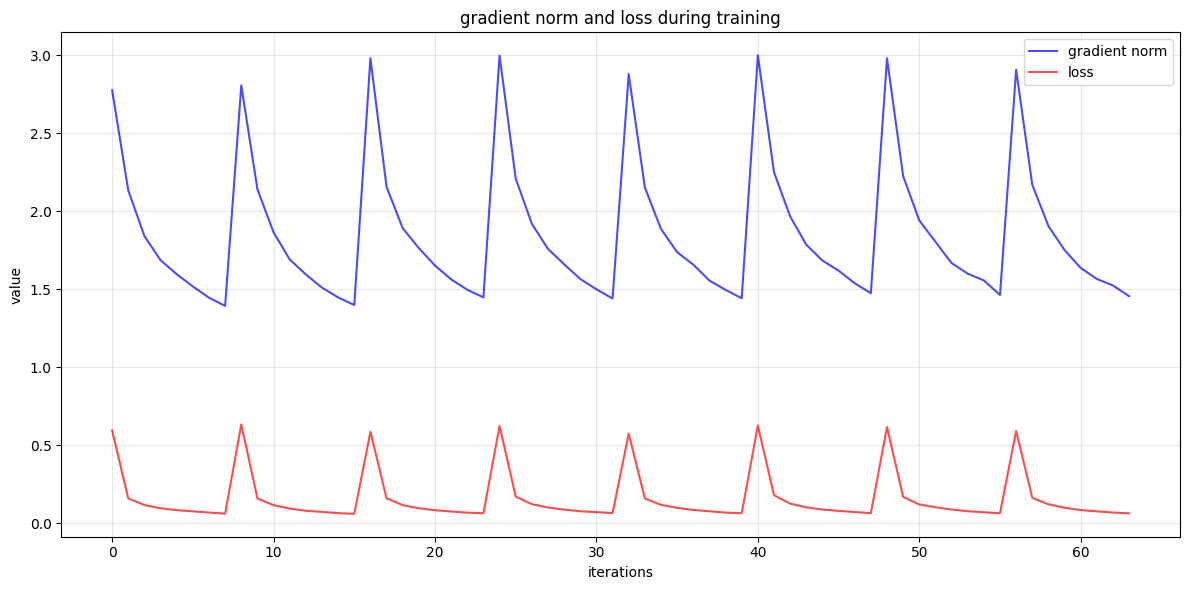

length mismatch: weights=24, losses=22


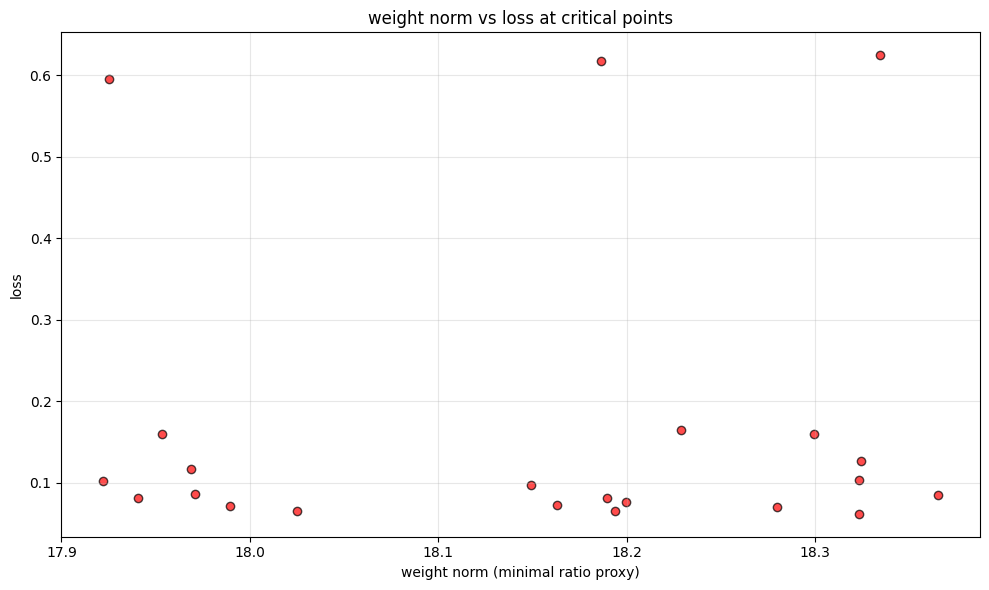

In [7]:
# run all experiments
weights, accuracies, losses, gradients = train_and_collect(epochs=8, save_every=3)
plot_weight_path(weights, accuracies)
plot_grad_and_loss(gradients, losses)
plot_minimal_analysis(weights, losses)